In [2]:
pip install mne

     |████████████████████████████████| 7.5 MB 15.6 MB/s 


In [1]:
import os
import numpy as np
import mne
import matplotlib.pyplot as plt
from mne.preprocessing import (ICA, corrmap)
from scipy.stats import ttest_rel
from tensorflow.keras import utils as np_utils
from sklearn.utils import shuffle

In [2]:
dataPath = '/content/drive/MyDrive/databbci'

In [3]:
import os

active = []
passive = []
cue = []


data_number = 0
for dir in os.listdir(dataPath):
  for filename in os.listdir(os.path.join(dataPath, dir)):
    #if filename.endswith(".vhdr"):
    tmp = os.path.join(os.path.join(dataPath, dir), filename)
      #with open(os.path.join(os.path.join(dataPath, dir), filename), 'r') as f: # open in readonly mode
    if filename.endswith("active.vhdr"):
      active.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
    elif filename.endswith("passive.vhdr"):
      passive.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
    elif filename.endswith("cue.vhdr"):
      cue.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
print(len(active))

<ipython-input-3-e82f2427b298>:17: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  passive.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
<ipython-input-3-e82f2427b298>:15: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  active.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
<ipython-input-3-e82f2427b298>:19: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  cue.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
<ipython-input-3-e82f2427b298>:19: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  cue.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
<ipython-input-3-e82f2427b298>:17: RuntimeWarning: Online software filter detected. Using software filter setting

3


## Testinng data

In [4]:
print(active[0].info)

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, Fz, F4, FC5, FC1, FCz, FC2, FC6, T7, C3, C1, Cz, ...
 chs: 32 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 50.0 Hz
 meas_date: 2018-11-27 12:28:32 UTC
 nchan: 32
 projs: []
 sfreq: 100.0 Hz
>


In [5]:
#to test the methodology
raw = active[0].copy()
#print(raw.info)
raw.pick_channels(['C1', 'Fz', 'C2', 'F3', 'F4', 'Pz', 'Oz', 'C3', 'Cz', 'C4'])
print(raw.info)

<Info | 7 non-empty values
 bads: []
 ch_names: F3, Fz, F4, C3, C1, Cz, C2, C4, Pz, Oz
 chs: 10 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 50.0 Hz
 meas_date: 2018-11-27 12:28:32 UTC
 nchan: 10
 projs: []
 sfreq: 100.0 Hz
>


In [6]:
events_from_annot, event_dict = mne.events_from_annotations(raw)
print(event_dict)
print(events_from_annot.size)

Used Annotations descriptions: ['Comment/ControlBox is not connected via USB', 'Comment/actiCAP Data On', 'Comment/actiCAP USB Power On', 'New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 77', 'Stimulus/S 78', 'Stimulus/S222']
{'Comment/ControlBox is not connected via USB': 10001, 'Comment/actiCAP Data On': 10002, 'Comment/actiCAP USB Power On': 10003, 'New Segment/': 99999, 'Stimulus/S  1': 1, 'Stimulus/S  2': 2, 'Stimulus/S 14': 14, 'Stimulus/S 15': 15, 'Stimulus/S 77': 77, 'Stimulus/S 78': 78, 'Stimulus/S222': 222}
1815


In [6]:
# file = fullfile(fDir, files{2});
# marker={'1' , 'active'; '2', 'ignore'};
# [EEG.data, EEG.marker, EEG.info]=Load_EEG(file,{'device','brainVision';'marker', marker;});
# CNT_2 = opt_eegStruct({EEG.data, EEG.marker, EEG.info}, field);
# CNT_2 = prep_selectChannels(CNT_2, {'Name',{'C1', 'Fz', 'C2', 'F3', 'F4', 'Pz', 'Oz', 'C3', 'Cz', 'C4'}})
# CNT_2=prep_filter(CNT_2, {'frequency', [0.4 40]});
# SMT_2=prep_segmentation(CNT_2, {'interval', [-290 1000]});
# SMT_2=prep_baseline(SMT_2, {'Time', [-100 0]});

# Set common average reference
#raw.set_eeg_reference('average', projection=False, verbose=False)

# Apply bandpass filter
raw.filter(l_freq=0.4, h_freq=40, fir_design='firwin', verbose=False)
#raw.filter(l_freq=0.4, h_freq=40, method = 'iir', verbose=False)

events, _ = mne.events_from_annotations(raw, verbose=False)
tmin, tmax = -0., 1.  # in s
baseline = (None, 0)


In [ ]:
print(events)

[[     0      0  99999]
 [     2      0  10002]
 [  4113      0     77]
 ...
 [131525      0     78]
 [133526      0     14]
 [133827      0    222]]


In [8]:
event_dict = {'active': 1, 'ignore': 2}
epochs = mne.Epochs(
    raw, events=events,
    event_id=event_dict, tmin=tmin,
    tmax=tmax, baseline=None, preload = True, verbose=False)
print(epochs.events.size)
print(epochs.event_id)

1620
{'active': 1, 'ignore': 2}


## All data load

In [4]:
def raw_to_data(raw, non_active = 0):
  raw.pick_channels(['C1', 'Fz', 'C2', 'F3', 'F4', 'Pz', 'Oz', 'C3', 'Cz', 'C4'])
  raw.filter(l_freq=0.4, h_freq=40, fir_design='firwin', verbose=False)
  #raw.filter(l_freq=0.4, h_freq=40, method = 'iir', verbose=False)

  events, _ = mne.events_from_annotations(raw, verbose=False)
  tmin, tmax = -0., 1.  # in s
  baseline = (None, 0)

  #passive -> ignore 
  #cue -> active
  # -> active, ignore
  event_dict = {'active': 1, 'ignore': 2}
  if non_active != 0:
    event_dict.clear()
    if non_active == 1: #passive
      event_dict = {'ignore': 2}
    else: # cue
      event_dict = {'active': 1}
  
  epochs = mne.Epochs(
    raw, events=events,
    event_id=event_dict, tmin=tmin,
    tmax=tmax, baseline=None, preload = True, verbose=False)
  # print(epochs.events.size)
  # print(epochs.event_id)
  # {'active': 1, 'ignore': 2}

  #preprocessing
  filt_raw = raw.copy().filter(l_freq=1., h_freq=None)
  ica = ICA(n_components=10, max_iter='auto', random_state=97)
  ica.fit(epochs)

  X = epochs.get_data()*1000  # MEG signals: n_epochs, n_meg_channels, n_times
  y = epochs.events[:, 2]  # target: auditory left vs visual left
  #print(X.shape, y.shape)

  return X, y

##Data dividing

In [7]:
train_X, train_y = raw_to_data(active[0], 0)

train_X.shape, train_y.shape

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 1.8s.


((540, 10, 101), (540,))

In [8]:
pas_X, pas_y = raw_to_data(passive[0], 1) #passive = 1
pas_X.shape, pas_y.shape

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 0.4s.


((180, 10, 101), (180,))

In [9]:
cue_X, cue_y = raw_to_data(cue[0],2)
cue_X.shape, cue_y.shape

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 0.2s.


((100, 10, 101), (100,))

In [10]:
test_X = np.append(cue_X, pas_X, axis = 0)
test_y = np.append(cue_y, pas_y, axis = 0)
test_y = np_utils.to_categorical(test_y-1)

test_X, test_y = shuffle(test_X, test_y, random_state=0)
test_X.shape, test_y.shape

((280, 10, 101), (280, 2))

## Preprocessing

In [23]:
from mne.preprocessing import (ICA, corrmap)
filt_raw = raw.copy().filter(l_freq=1., h_freq=None)
ica = ICA(n_components=10, max_iter='auto', random_state=97)
ica.fit(epochs)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 1.4s.


Method,fastica
Fit,32 iterations on epochs (54540 samples)
ICA components,10
Explained variance,100.0 %
Available PCA components,10
Channel types,eeg
ICA components marked for exclusion,—


Creating RawArray with float64 data, n_channels=10, n_times=134184
    Range : 0 ... 134183 =      0.000 ...  1341.830 secs
Ready.
Using matplotlib as 2D backend.
Opening ica-browser...


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


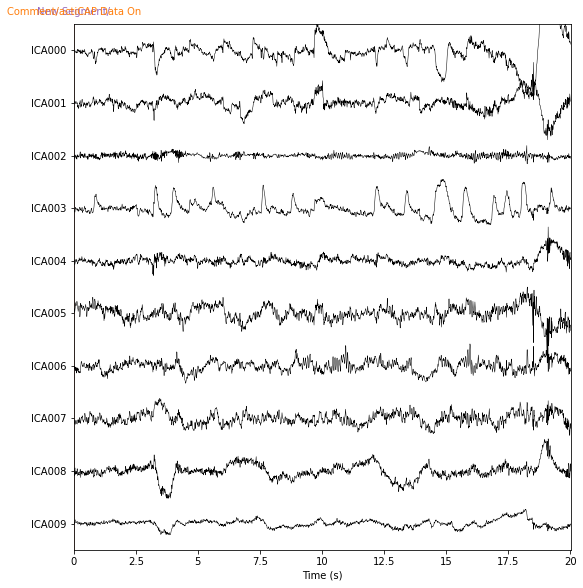

In [24]:
raw.load_data()
ica.plot_sources(raw, show_scrollbars=False);

Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 1 ICA component
    Projecting back using 10 PCA components


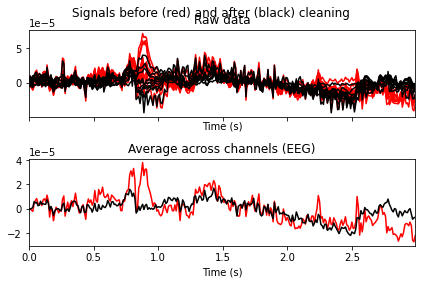

In [25]:
ica.plot_overlay(raw, exclude=[0], picks='eeg');

## Models LDA

In [12]:
X = epochs.get_data()  # MEG signals: n_epochs, n_meg_channels, n_times
y = epochs.events[:, 2]  # target: auditory left vs visual left
print(X.shape, y.shape)

NameError: ignored

In [15]:
train_lda = train_X.copy().reshape(540,-1)
test_lda = test_X.copy().reshape(280, -1)
print(train_lda.shape, test_lda.shape)


(540, 1010) (280, 1010)


In [16]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# LDA
clf = LinearDiscriminantAnalysis()
clf.fit(train_lda, train_y)

LinearDiscriminantAnalysis()

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_pred = clf.predict(test_lda)
cm = confusion_matrix(test_y, y_pred)
print(cm)
print('Accuracy' + str(accuracy_score(test_y, y_pred)))

[[ 66  34]
 [ 65 115]]
Accuracy0.6464285714285715


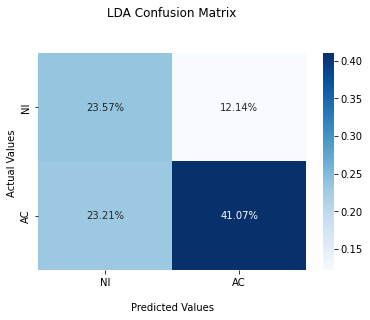

In [22]:
import seaborn as sns

ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('LDA Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['NI','AC'])
ax.yaxis.set_ticklabels(['NI','AC'])

## Display the visualization of the Confusion Matrix.
plt.show()

## CNN

In [11]:
train_X = train_X.reshape(-1, 10,101, 1)
test_X = test_X.reshape(-1, 10,101, 1)
train_X.shape, test_X.shape

((540, 10, 101, 1), (280, 10, 101, 1))

In [12]:
classes = np.unique(train_y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  2
Output classes :  [1 2]


In [13]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_y, test_size=0.2, random_state=13)

In [14]:
from collections import Counter

n = Counter(train_label)
ratio = int(n[1]/n[2])
print(ratio, n)

train_label_categorical = np_utils.to_categorical(train_label-1)
valid_label_categorical = np_utils.to_categorical(valid_label-1)

2 Counter({1: 288, 2: 144})


In [15]:
class_weights={0:1, 1:2}
class_weights

{0: 1, 1: 2}

In [16]:
train_X.shape, valid_X.shape, train_label_categorical.shape, valid_label_categorical.shape

((432, 10, 101, 1), (108, 10, 101, 1), (432, 2), (108, 2))

In [14]:
np.sum(train_label, axis=0)

576

In [17]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
import tensorflow as tf

In [18]:
batch_size = 16
epochs = 100
num_classes = 2

In [ ]:
# layers = [
#     imageInputLayer([S_t 10 1])
    
#     convolution2dLayer([40, 4],8,'Padding','same')
#     batchNormalizationLayer
#     reluLayer
#     dropoutLayer
    
# %     maxPooling2dLayer(2,'Stride',2)
    
#     convolution2dLayer([80, 4],16,'Padding','same')
#     batchNormalizationLayer
#     reluLayer
#     dropoutLayer
    
# %     maxPooling2dLayer(2,'Stride',2)
    
#     convolution2dLayer([80, 4],32,'Padding','same')
#     batchNormalizationLayer
#     reluLayer
    
#     fullyConnectedLayer(2)
#     softmaxLayer
#     classificationLayer];

In [19]:
cnn_model = Sequential()
cnn_model.add(Conv2D(8, kernel_size=(40, 4),activation='relu',input_shape=(10,101,1),padding='same'))
# cnn_model.add(MaxPooling2D((2, 2),padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(16, (80, 4), activation='relu',padding='same'))
# cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(32, (80, 4), activation='relu',padding='same'))         
# cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.25))

cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(num_classes, activation='sigmoid'))

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint

# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1,
                               save_best_only=True)

In [25]:
from tensorflow.keras.optimizers import SGD
opt = SGD(lr=0.01)

cnn_model.compile(optimizer=opt,
          loss = "categorical_crossentropy",
          metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [26]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 10, 101, 8)        1288      
                                                                 
 batch_normalization (BatchN  (None, 10, 101, 8)       32        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 10, 101, 8)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 101, 16)       40976     
                                                                 
 batch_normalization_1 (Batc  (None, 10, 101, 16)      64        
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 10, 101, 16)       0

In [27]:
cnn_train = cnn_model.fit(train_X, train_label_categorical, batch_size=batch_size, 
                          epochs=epochs,
                          verbose=1,
                          validation_data=(valid_X, valid_label_categorical), 
                          callbacks=[checkpointer], 
                          class_weight = class_weights
                          )

Epoch 1/100
27/27 [==============================] - ETA: 0s - loss: 2.6262 - accuracy: 0.5694
Epoch 1: val_loss improved from inf to 0.72456, saving model to /tmp/checkpoint.h5
27/27 [==============================] - 29s 988ms/step - loss: 2.6262 - accuracy: 0.5694 - val_loss: 0.7246 - val_accuracy: 0.3333
Epoch 2/100
27/27 [==============================] - ETA: 0s - loss: 0.9951 - accuracy: 0.6597
Epoch 2: val_loss improved from 0.72456 to 0.66820, saving model to /tmp/checkpoint.h5
27/27 [==============================] - 30s 1s/step - loss: 0.9951 - accuracy: 0.6597 - val_loss: 0.6682 - val_accuracy: 0.6667
Epoch 3/100
27/27 [==============================] - ETA: 0s - loss: 0.8348 - accuracy: 0.6481
Epoch 3: val_loss did not improve from 0.66820
27/27 [==============================] - 27s 987ms/step - loss: 0.8348 - accuracy: 0.6481 - val_loss: 0.9053 - val_accuracy: 0.3333
Epoch 4/100
27/27 [==============================] - ETA: 0s - loss: 0.7900 - accuracy: 0.6852
Epoch 4: v

In [28]:
test_eval = cnn_model.evaluate(test_X, test_y, verbose=0)

In [37]:
probs       = cnn_model.predict(test_X)

In [44]:
pip install pyriemann

     |████████████████████████████████| 42 kB 525 kB/s 
  Created wheel for pyriemann: filename=pyriemann-0.2.7-py2.py3-none-any.whl size=49770 sha256=af826ec2301bab901c4c75d868dbe504c54ceed21a318b767b1b3cbffe24506f
  Stored in directory: /root/.cache/pip/wheels/5c/b7/55/27dcb08ed8fb58da8c1be108c23928ffb9125c9c1da2ddfb53
Successfully built pyriemann


In [71]:
import sklearn.metrics as metrics

y_pred_ohe = cnn_model.predict(test_X)  # shape=(n_samples, 12)

In [72]:
y_pred_labels = np.argmax(y_pred_ohe, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)
test_y = np.argmax(test_y, axis=1) 
y_pred_labels

array([1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1])

In [73]:
confusion_matrix = metrics.confusion_matrix(y_true=test_y, y_pred=y_pred_labels)

In [74]:
confusion_matrix

array([[ 85,  15],
       [ 22, 158]])

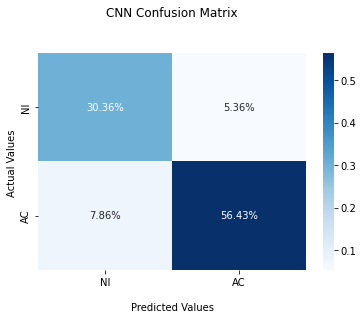

In [76]:
import seaborn as sns

ax = sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('CNN Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['NI','AC'])
ax.yaxis.set_ticklabels(['NI','AC'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [38]:
probs       = cnn_model.predict(test_X)
preds       = probs.argmax(axis = -1)  
acc         = np.mean(preds == test_y.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))

Classification accuracy: 0.867857 


In [32]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.5097537040710449
Test accuracy: 0.8678571581840515


In [30]:
cnn_model.save("cnn_model_dropout.h5py")

INFO:tensorflow:Assets written to: cnn_model_dropout.h5py/assets


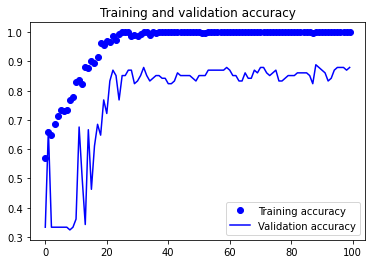

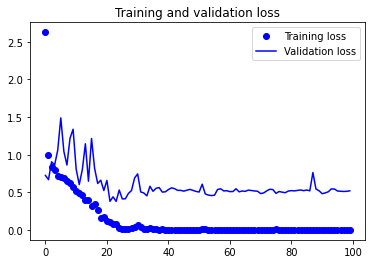

In [31]:
accuracy = cnn_train.history['accuracy']
val_accuracy = cnn_train.history['val_accuracy']
loss = cnn_train.history['loss']
val_loss = cnn_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## CNN for all subjects

In [5]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam
import sklearn.metrics as metrics
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [14]:
def cnn_101(train_X, test_X, train_y, test_y):
  train_X = train_X.reshape(-1, 10,101, 1)
  test_X = test_X.reshape(-1, 10,101, 1)

  #train_X, train_y = shuffle(test_X, test_y, random_state=2)
  #test_X, test_y = shuffle(test_X, test_y, random_state=2)
  
  train_X,valid_X,train_label,valid_label = train_test_split(train_X, 
                                                             train_y, 
                                                             test_size=0.2, 
                                                             random_state=13)

  train_label_categorical = np_utils.to_categorical(train_label-1)
  valid_label_categorical = np_utils.to_categorical(valid_label-1)
  test_y = np_utils.to_categorical(test_y-1)

  batch_size = 16
  epochs = 100
  num_classes = 2

  cnn_model = Sequential()
  cnn_model.add(Conv2D(8, kernel_size=(40, 4),activation='relu',input_shape=(10,101,1),padding='same'))
  # cnn_model.add(MaxPooling2D((2, 2),padding='same'))
  cnn_model.add(BatchNormalization())
  cnn_model.add(Dropout(0.2))

  cnn_model.add(Conv2D(16, (80, 4), activation='relu',padding='same'))
  # cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
  cnn_model.add(BatchNormalization())
  cnn_model.add(Dropout(0.25))

  cnn_model.add(Conv2D(32, (80, 4), activation='relu',padding='same'))         
  # cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
  cnn_model.add(BatchNormalization())
  cnn_model.add(Dropout(0.3))

  cnn_model.add(Flatten())
  cnn_model.add(Dense(128, activation='relu'))
  cnn_model.add(Dense(num_classes, activation='sigmoid'))

  # set a valid path for your system to record model checkpoints
  checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1,
                               save_best_only=True)
  
  y_integers = np.argmax(train_label_categorical, axis=1)
  class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
  d_class_weights = dict(enumerate(class_weights))

  opt = SGD(lr=0.01)
  #opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)

  cnn_model.compile(optimizer=opt,
          loss = "categorical_crossentropy",
          metrics=['accuracy'])
  
  cnn_train = cnn_model.fit(train_X, train_label_categorical, batch_size=batch_size, 
                          epochs=epochs,
                          verbose=1,
                          validation_data=(valid_X, valid_label_categorical), 
                          callbacks=[checkpointer], 
                          class_weight = d_class_weights
                          )

  test_eval = cnn_model.evaluate(test_X, test_y, verbose=0)

  pred_prob_conv = cnn_model.predict(test_X)

  pred_y_conv = np.argmax(pred_prob_conv, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)
  test_y_conv = np.argmax(test_y, axis=1)

  return cnn_model, cnn_train, test_eval, test_y_conv, pred_y_conv


In [7]:
def vis_confusion_matrix(test_y_conv, pred_y_conv, subject):
  confusion_matrix = metrics.confusion_matrix(y_true=test_y, 
                                              y_pred=y_pred_labels)
  
  ax = sns.heatmap(confusion_matrix, annot=True, 
            fmt='.2%', cmap='Blues')

  ax.set_title('CNN Confusion Matrix | Subject '+ (subject+1) +'\n\n');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['NI','AC'])
  ax.yaxis.set_ticklabels(['NI','AC'])

  ## Display the visualization of the Confusion Matrix.
  plt.show()

In [8]:
def vis_acc_loss(cnn_train):
  accuracy = cnn_train.history['accuracy']
  val_accuracy = cnn_train.history['val_accuracy']
  loss = cnn_train.history['loss']
  val_loss = cnn_train.history['val_loss']
  epochs = range(len(accuracy))
  plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
  plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

In [9]:
cnn_models = []

In [10]:
subject = 0
train_X, train_y = raw_to_data(active[subject], 0)
pas_X, pas_y = raw_to_data(passive[subject], 1) #passive = 1
cue_X, cue_y = raw_to_data(cue[subject],2) #ignore = 2

test_X = np.append(cue_X, pas_X, axis = 0)
test_y = np.append(cue_y, pas_y, axis = 0)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 1.6s.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- F

In [47]:

#train_X, train_y = shuffle(test_X, test_y, random_state=0)
# test_X, test_y = shuffle(test_X, test_y, random_state=0)

# from collections import Counter

# n = Counter(train_y)
# ratio = int(n[1]/n[2])
# print(ratio, n)
# print(train_y)

# train_label_categorical = np_utils.to_categorical(train_y-1)
# print(train_label_categorical)

# # train_X,valid_X,train_label,valid_label = train_test_split(train_X, 
# #                                                             train_y, 
# #                                                             test_size=0.3, 
# #                                                             random_state=13)

# n = Counter(train_label)
# ratio = int(n[1]/n[2])
# print(ratio, n)

# n = Counter(valid_label)
# ratio = int(n[1]/n[2])
# print(ratio, n)

# train_label, valid_label


2 Counter({1: 360, 2: 180})
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2
 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

{0: 0.75, 1: 1.5}

In [15]:
cnn_model, cnn_train, test_eval, test_y_conv, pred_y_conv = cnn_101(train_X, 
                                                                    test_X, 
                                                                    train_y, 
                                                                    test_y)

cnn_models.append(cnn_model)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


27/27 [==============================] - ETA: 0s - loss: 1.6611 - accuracy: 0.5486
Epoch 1: val_loss improved from inf to 0.69587, saving model to /tmp/checkpoint.h5
27/27 [==============================] - 27s 986ms/step - loss: 1.6611 - accuracy: 0.5486 - val_loss: 0.6959 - val_accuracy: 0.3333
Epoch 2/100
27/27 [==============================] - ETA: 0s - loss: 0.7082 - accuracy: 0.6157
Epoch 2: val_loss improved from 0.69587 to 0.68222, saving model to /tmp/checkpoint.h5
27/27 [==============================] - 26s 972ms/step - loss: 0.7082 - accuracy: 0.6157 - val_loss: 0.6822 - val_accuracy: 0.6759
Epoch 3/100
27/27 [==============================] - ETA: 0s - loss: 0.6089 - accuracy: 0.6759
Epoch 3: val_loss improved from 0.68222 to 0.65351, saving model to /tmp/checkpoint.h5
27/27 [==============================] - 26s 976ms/step - loss: 0.6089 - accuracy: 0.6759 - val_loss: 0.6535 - val_accuracy: 0.6667
Epoch 4/100
27/27 [==============================] - ETA: 0s - loss: 0.557

TypeError: ignored

In [16]:
cnn_model.save("cnn_model.h5py")

vis_confusion_matrix(test_y_conv, pred_y_conv, subject)

vis_acc_loss(cnn_train)

INFO:tensorflow:Assets written to: cnn_model.h5py/assets


NameError: ignored